In [42]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek


os.getcwd()

import configparser
config = configparser.ConfigParser()
config.read_file(open('config.ini'))

client_attributes_file_path = config['data-files']['clients_attributes']
active_promos_file_path = config['data-files']['active_promos']
executed_promos_file_path = config['data-files']['executed_promos']
sales_file_path = config['data-files']['sales']


In [2]:
# for root, dirs, files in os.walk("."):
#     for filename in files:
#         print(filename)

In [3]:
sales = pd.read_csv(sales_file_path, encoding='latin-1')
# sales[sales['Dcto'] < 0]
sales

Cliente   Año  Mes  ClaseEnvase  SegmentoPrecio  Marca  Cupo  \
0              1  2018    1            2             2.0     44  10.0   
1              1  2018    1            2             4.0     18  16.0   
2              1  2018    6            2             1.0      2   6.0   
3              1  2018    7            1             2.0     37  34.0   
4              1  2018    8            2             1.0      2  16.0   
...          ...   ...  ...          ...             ...    ...   ...   
1894247    15068  2019    8            1             2.0     44  32.0   
1894248    15069  2019    3            1             2.0     44  32.0   
1894249    15069  2019    4            1             2.0     44  32.0   
1894250    15069  2019    4            2             1.0      2   6.0   
1894251    15069  2019    7            1             2.0     44  29.0   

               Nr    Hl    Dcto  
0         6352.94  0.03     0.0  
1        99130.50  0.45     0.0  
2        11605.40  0.07 -2880.0  
3         1944.01  0.01     0.0  
4        16250.18  0.06     0.0  
...           ...   ...     ...  
1894247   3777.28  0.01     0.0  
1894248   6295.46  0.02     0.0  
1894249   6295.46  0.02     0.0  
1894250  15741.56  0.08     0.0  
1894251  16102.33  0.09     0.0  

[1894252 rows x 10 columns]

In [4]:
# 0	297601	8410	29	9
# sales[(sales['Cliente'] == 8410) & (sales['Marca'] == 29) & (sales['Cupo'] == 9)]
x = sales[(sales['Cliente'] == 8410) & (sales['Marca'] == 29) & (sales['Cupo'] == 9)]
x['Cliente']

853830    8410
Name: Cliente, dtype: int64

In [5]:
executed_promos = pd.read_csv(executed_promos_file_path, encoding='latin-1')
sanitized_executed_promos = executed_promos.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
sanitized_executed_promos

CodigoDC  Cliente  Marca  Cupo
0        297601     8410     29     9
1        297601     9337     29     9
2        309843     7404     40    16
3        309874     4017     40    16
4        309910     6316     40    16
...         ...      ...    ...   ...
27763    646815     2144     29     9
27764    646976       28     29     9
27765    647188    10023     29     9
27766    648099    10193     29     9
27791    651597     4430     40    16

[8426 rows x 4 columns]

In [6]:
active_promos = pd.read_csv(active_promos_file_path, encoding='latin-1')
active_promos

CodigoDC  Marca  Cupo Fecha_Desde Fecha_Hasta  Cliente
0         297601     29     9  2018-08-06  2018-08-30     3213
1         297601     29     9  2018-08-06  2018-08-30     3795
2         297601     29     9  2018-08-06  2018-08-30    11816
3         298856     40    16  2018-08-12  2018-08-19     8444
4         309916     40    16  2018-08-12  2018-08-19     8488
...          ...    ...   ...         ...         ...      ...
422432    688354     40    16  2019-09-25  2019-09-26    14435
422433    688355     29     9  2019-09-25  2019-09-26      320
422434    688355     29     9  2019-09-25  2019-09-26     3117
422435    688355     29     9  2019-09-25  2019-09-26     3503
422436    688355     29     9  2019-09-25  2019-09-26     6372

[422437 rows x 6 columns]

In [7]:
clients_attributes = pd.read_csv(client_attributes_file_path, encoding='latin-1')
clients_attributes

Cliente FechaAltaCliente  Region  Gerencia  SubCanal  TipoPoblacion  \
0            1       2009-03-03       4        21        12              1   
1            9       2009-03-03       4        21         9              2   
2           15       2009-03-03       4        21         9              2   
3           37       2009-03-03       4        21        16              2   
4           43       2009-03-03       4        21         9              2   
...        ...              ...     ...       ...       ...            ...   
15064    15040       2019-03-07       1        16         9              2   
15065    15043       2019-03-07       1        20        15              2   
15066    15052       2019-03-09       3         7        10              2   
15067    15065       2019-03-16       4        21         9              2   
15068    15069       2019-03-18       4        14         9              2   

       Estrato  EF  
0            1   1  
1            3   1  
2            3   0  
3            3   1  
4            3   0  
...        ...  ..  
15064        1   0  
15065        2   1  
15066        2   0  
15067        2   0  
15068        1   0  

[15069 rows x 8 columns]

In [8]:
sales_exec_promos = sales.merge(sanitized_executed_promos, how = 'left', on = ['Cliente', 'Marca', 'Cupo'])
sales_exec_promos.loc[sales_exec_promos['CodigoDC'].isnull() == False, 'ES_PROMO'] = 'SI'
sales_exec_promos.loc[sales_exec_promos['CodigoDC'].isnull() == True, 'ES_PROMO'] = 'NO'

sales_exec_promos


Cliente   Año  Mes  ClaseEnvase  SegmentoPrecio  Marca  Cupo  \
0              1  2018    1            2             2.0     44  10.0   
1              1  2018    1            2             4.0     18  16.0   
2              1  2018    6            2             1.0      2   6.0   
3              1  2018    7            1             2.0     37  34.0   
4              1  2018    8            2             1.0      2  16.0   
...          ...   ...  ...          ...             ...    ...   ...   
1894247    15068  2019    8            1             2.0     44  32.0   
1894248    15069  2019    3            1             2.0     44  32.0   
1894249    15069  2019    4            1             2.0     44  32.0   
1894250    15069  2019    4            2             1.0      2   6.0   
1894251    15069  2019    7            1             2.0     44  29.0   

               Nr    Hl    Dcto  CodigoDC ES_PROMO  
0         6352.94  0.03     0.0       NaN       NO  
1        99130.50  0.45     0.0       NaN       NO  
2        11605.40  0.07 -2880.0       NaN       NO  
3         1944.01  0.01     0.0       NaN       NO  
4        16250.18  0.06     0.0       NaN       NO  
...           ...   ...     ...       ...      ...  
1894247   3777.28  0.01     0.0       NaN       NO  
1894248   6295.46  0.02     0.0       NaN       NO  
1894249   6295.46  0.02     0.0       NaN       NO  
1894250  15741.56  0.08     0.0       NaN       NO  
1894251  16102.33  0.09     0.0       NaN       NO  

[1894252 rows x 12 columns]

In [31]:
df = sales_exec_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
df.columns.tolist()

['Cliente',
 'Año',
 'Mes',
 'ClaseEnvase',
 'SegmentoPrecio',
 'Marca',
 'Cupo',
 'Nr',
 'Hl',
 'Dcto',
 'CodigoDC',
 'ES_PROMO',
 'FechaAltaCliente',
 'Region',
 'Gerencia',
 'SubCanal',
 'TipoPoblacion',
 'Estrato',
 'EF']

In [33]:
df=df['Cliente', 'Año', 'Mes', 'ClaseEnvase', 'SegmentoPrecio', 'Marca', 'Cupo', 'Nr', 'Hl', 'Dcto', 'CodigoDC', 
      'FechaAltaCliente', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF','ES_PROMO']
df

Cliente   Año  Mes  ClaseEnvase  SegmentoPrecio  Marca  Cupo  \
0              1  2018    1            2             2.0     44  10.0   
1              1  2018    1            2             4.0     18  16.0   
2              1  2018    6            2             1.0      2   6.0   
3              1  2018    7            1             2.0     37  34.0   
4              1  2018    8            2             1.0      2  16.0   
...          ...   ...  ...          ...             ...    ...   ...   
1894247    15068  2019    8            1             2.0     44  32.0   
1894248    15069  2019    3            1             2.0     44  32.0   
1894249    15069  2019    4            1             2.0     44  32.0   
1894250    15069  2019    4            2             1.0      2   6.0   
1894251    15069  2019    7            1             2.0     44  29.0   

               Nr    Hl    Dcto  CodigoDC FechaAltaCliente  Region  Gerencia  \
0         6352.94  0.03     0.0       NaN       2009-03-03       4        21   
1        99130.50  0.45     0.0       NaN       2009-03-03       4        21   
2        11605.40  0.07 -2880.0       NaN       2009-03-03       4        21   
3         1944.01  0.01     0.0       NaN       2009-03-03       4        21   
4        16250.18  0.06     0.0       NaN       2009-03-03       4        21   
...           ...   ...     ...       ...              ...     ...       ...   
1894247   3777.28  0.01     0.0       NaN       2019-03-18       1         5   
1894248   6295.46  0.02     0.0       NaN       2019-03-18       4        14   
1894249   6295.46  0.02     0.0       NaN       2019-03-18       4        14   
1894250  15741.56  0.08     0.0       NaN       2019-03-18       4        14   
1894251  16102.33  0.09     0.0       NaN       2019-03-18       4        14   

         SubCanal  TipoPoblacion  Estrato  EF ES_PROMO  
0              12              1        1   1       NO  
1              12              1        1   1       NO  
2              12              1        1   1       NO  
3              12              1        1   1       NO  
4              12              1        1   1       NO  
...           ...            ...      ...  ..      ...  
1894247         9              2        3   1       NO  
1894248         9              2        1   0       NO  
1894249         9              2        1   0       NO  
1894250         9              2        1   0       NO  
1894251         9              2        1   0       NO  

[1894252 rows x 19 columns]

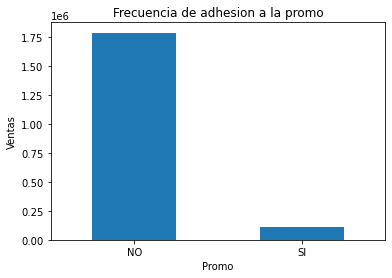

In [34]:
count_class = pd.value_counts(df['ES_PROMO'], sort = True)
count_class.plot(kind= 'bar', rot= 0)
plt.title('Frecuencia de adhesion a la promo')
plt.xlabel('Promo')
plt.ylabel('Ventas')
plt.show()

In [35]:
d = defaultdict(preprocessing.LabelEncoder)

In [36]:
tipos = df.columns.to_series().groupby(df.dtypes).groups

object_list = list(tipos[np.dtype('object')])
object_list

['FechaAltaCliente', 'ES_PROMO']

In [46]:
fit=df.apply(lambda x: d[x.name].fit_transform(x) if x.name in object_list else x)

fit.apply(lambda x: d[x.name].inverse_transform(x) if x.name in object_list else x)

df=df.apply(lambda x: d[x.name].transform(x) if x.name in object_list else x)
df.head(50)

Cliente   Año  Mes  ClaseEnvase  SegmentoPrecio  Marca  Cupo         Nr  \
0         1  2018    1            2             2.0     44  10.0    6352.94   
1         1  2018    1            2             4.0     18  16.0   99130.50   
2         1  2018    6            2             1.0      2   6.0   11605.40   
3         1  2018    7            1             2.0     37  34.0    1944.01   
4         1  2018    8            2             1.0      2  16.0   16250.18   
5         1  2018    9            1             2.0     44  30.0    8901.19   
6         1  2018    9            1             2.0     44  32.0   16944.77   
7         1  2018   10            1             2.0     44  32.0   12551.68   
8         1  2018   10            2             1.0      6  12.0   93730.38   
9         1  2018   11            1             1.0      9  25.0   31160.19   
10        1  2018   11            1             2.0     44  29.0    8026.08   
11        1  2018   11            2             1.0      2  16.0   32500.37   
12        1  2018   12            1             2.0     44  30.0    8901.19   
13        1  2018   12            2             1.0      6  16.0  277756.17   
14        1  2019    1            2             1.0      6  16.0   46292.69   
15        1  2019    2            1             1.0      2  26.0    9588.56   
16        1  2019    2            1             2.0      1  35.0    3600.00   
17        1  2019    2            2             1.0     40  16.0   38896.30   
18        1  2019    2            2             2.0     44  16.0   18602.51   
19        1  2019    3            1             1.0      2  26.0   19177.12   
20        1  2019    3            1             2.0     44  29.0   24153.50   
21        1  2019    3            2             1.0      2  16.0   32902.91   
22        1  2019    5            2             2.0     44  16.0    8397.29   
23        1  2019    6            1             1.0      2  26.0   38354.24   
24        1  2019    6            2             2.0     44  16.0    9330.32   
25        1  2019    7            1             2.0     43  32.0    1259.09   
26        1  2019    8            1             2.0     44  30.0   17858.03   
27        1  2019    8            2             1.0      2  16.0   65805.83   
28        2  2018    1            1             2.0     44  29.0   24277.31   
29        2  2018    1            1             4.0     31   8.0   79984.80   
30        2  2018    2            1             1.0      2  26.0   58244.09   
31        2  2018    2            1             1.0     28  25.0    7724.52   
32        2  2018    3            1             1.0     40  22.0   36714.81   
33        2  2018    3            1             3.0     23  26.0  126606.09   
34        2  2018    3            1             4.0     31   8.0   89437.53   
35        2  2018    4            1             1.0     40  22.0   42489.07   
36        2  2018    4            1             3.0     46  23.0   16085.65   
37        2  2018    5            1             2.0     37  34.0    3888.02   
38        2  2018    6            1             4.0     31   8.0    2658.16   
39        2  2018    7            1             2.0     44  33.0    7459.76   
40        2  2018    7            1             4.0     17  23.0   24253.46   
41        2  2018    8            2             3.0     34   7.0   40810.49   
42        2  2018    9            1             1.0      6  25.0   42409.70   
43        2  2018    9            1             1.0     40  22.0   50568.79   
44        2  2018    9            1             4.0     17  23.0   30915.08   
45        2  2018   11            2             1.0      6  16.0   45680.08   
46        2  2018   11            2             2.0     44  16.0    9301.25   
47        2  2019    1            1             1.0      2  26.0   80513.15   
48        2  2019    2            1             1.0      2  26.0   28238.98   
49        2  2019    2            1             1.0   

In [38]:
df['SegmentoPrecio'].isnull().any()

True

In [39]:
class_y= list(d['ES_PROMO'].classes_)
class_y

['NO', 'SI']

In [40]:
d['ES_PROMO'].transform(class_y)

array([0, 1], dtype=int64)

In [41]:
x, y = df.iloc[:, 0:18].values, df.iloc[:, 18].values

x_train, x_test, y_train, y_test =\
    train_test_split(x, y, 
                     test_size=0.3,
                     random_state=0, 
                     stratify=y)

In [45]:
os_us= SMOTETomek(0.8)
x_t_st, y_t_st= os_us.fit_sample(x_train, y_train)

C:\Users\Tjander\AppData\Roaming\Python\Python38\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=0.8 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').